# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug sagemaker boto3

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
# Hyper parameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
#TODO: Fetch and upload the data to AWS S3
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

## Dataset
This project uses the dog breed classification dataset, which contains images of various dog breeds. The dataset is divided into training, validation, and testing sets. Each class in the dataset represents a different breed of dog.

The dataset can be downloaded from the following link and then uploaded to an S3 bucket for training:


In [4]:
BUCKET = 'sagemaker-us-east-1-912838639750'

# Upload metadata
sagemaker_session = sagemaker.Session()
PREFIX = 'Project/dog-breed-dataset'
# ---
DATASET_LOCAL_DIR = "dogImages"

In [27]:
dataset_dir_path = sagemaker_session.upload_data(
    path=DATASET_LOCAL_DIR,
    bucket=BUCKET,
    key_prefix=PREFIX
)

print(f"Dataset directory path on S3 : {dataset_dir_path}")

Dataset directory path on S3 : s3://sagemaker-us-east-1-912838639750/Project/dog-breed-dataset


In [5]:
dataset_dir_path = 's3://sagemaker-us-east-1-912838639750/Project/dog-breed-dataset'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
# Setup hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [7]:

import os 
#TODO: Create estimators for your HPs
cwd = os.getcwd()

# Create the model estimator
role = sagemaker.get_execution_role()
estimator = PyTorch(
    entry_point=os.path.join(cwd, "hpo.py"),
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [12]:
# TODO: Fit your HP Tuner
valid_tuner_job_name = 'pytorch-tune-240623'
tuner.fit({'data': dataset_dir_path}, wait=True, job_name=valid_tuner_job_name)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................!


In [8]:
# TODO: Get the best estimators and the best HPs

tuner_job_name = 'pytorch-tune-240623'
tuner = sagemaker.tuner.HyperparameterTuner.attach(tuner_job_name)

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hyperparameters = best_estimator.hyperparameters()
print(best_estimator_hyperparameters)


2024-06-23 07:56:47 Starting - Preparing the instances for training
2024-06-23 07:56:47 Downloading - Downloading the training image
2024-06-23 07:56:47 Training - Training image download completed. Training in progress.
2024-06-23 07:56:47 Uploading - Uploading generated training model
2024-06-23 07:56:47 Completed - Resource released due to keep alive period expiry
{'_tuning_objective_metric': '"average test loss"', 'batch-size': '"128"', 'epochs': '"2"', 'lr': '0.007482771430746152', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-tune-240623"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-912838639750/pytorch-tune-240623/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
# Creating the hyperparameters dictionary
hyperparameters = {
    "batch-size": best_estimator_hyperparameters['batch-size'].strip('"'),
    "lr": best_estimator_hyperparameters['lr'],
    "epochs": best_estimator_hyperparameters['epochs'].strip('"')
}

print(hyperparameters)

{'batch-size': '128', 'lr': '0.007482771430746152', 'epochs': '2'}


In [10]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
# TODO: Create and fit an estimator

cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd, "train_model.py"),
    base_job_name="Image-classification-Project-debugging",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

In [17]:
# fitting the estimator
estimator.fit({'data': dataset_dir_path}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Image-classification-Project-debugging-2024-06-23-16-51-34-759


2024-06-23 16:51:35 Starting - Starting the training job...
2024-06-23 16:52:03 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2024-06-23 16:52:23 Downloading - Downloading input data...
2024-06-23 16:53:04 Downloading - Downloading the training image...
2024-06-23 16:53:24 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-06-23 16:53:22,985 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-06-23 16:53:22,987 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-23 16:53:22,994 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-06-23 16:53:22,996 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-06-23 16:53:23,184 sagemaker-training-toolki

In [18]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(description)

{'TrainingJobName': 'Image-classification-Project-debugging-2024-06-23-16-51-34-759', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:912838639750:training-job/Image-classification-Project-debugging-2024-06-23-16-51-34-759', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '"128"', 'epochs': '"2"', 'lr': '"0.007482771430746152"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"Image-classification-Project-debugging-2024-06-23-16-51-34-759"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.co

In [19]:
# TODO: Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


Training jobname: Image-classification-Project-debugging-2024-06-23-16-51-34-759
Region: us-east-1


In [20]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-06-23 17:12:05.545 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:18 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-23 17:12:05.565 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/debug-output
[2024-06-23 17:12:05.921 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:18 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/debug-output/index/000000000/000000000016_worker_0.json . Will retry now


In [21]:
print(trial.tensor_names())

[2024-06-23 17:12:08.675 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:18 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-06-23 17:12:09.712 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'ResNet_bn1.bias', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.bias', 'ResNet_fc.weight', 'ResNet_layer1.0.bn1.bias', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.bias', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.bn3.bias', 'ResNet_layer1.0.bn3.weight', 'ResNet_layer1.0.conv1.weight', 'ResNet_layer1.0.conv2.weight', 'ResNet_layer1.0.conv3.weight', 'ResNet_layer1.0.downsample.0.weight', 'ResNet_layer1.0.downsample.1.bias', 'ResNet_layer1.0.downsample.1.weight', 'ResNet_layer1.1.bn1.bias', 'ResNet_layer1.1.bn1.weight', 'ResNet_layer1.1.bn2.bias', 'ResNet_layer1.1.bn2.weight', 'ResNet_layer1.1.bn3.bias', 'ResNet_layer1.1.bn3.weight', 'ResNet_layer

In [22]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

106
21


In [23]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [24]:
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


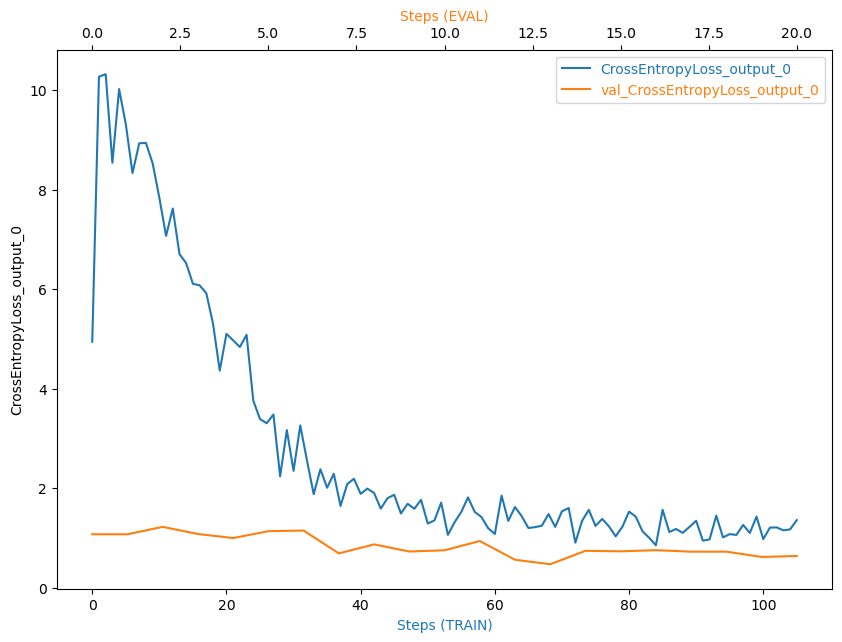

In [25]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [26]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [27]:
! aws s3 ls {rule_output_path} --recursive

2024-06-23 17:11:39     374849 Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-06-23 17:11:38     222768 Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-06-23 17:11:33        192 Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-06-23 17:11:33        200 Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-06-23 17:11:33       1827 Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-06-23 17:11:33        127 Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease

In [28]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east

In [29]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [30]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [31]:
from sagemaker.pytorch import PyTorchModel
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/output/model.tar.gz


In [34]:
# TODO: Deploy your model to an endpoint
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8"
)

In [35]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-912838639750/Image-classification-Project-debugging-2024-06-23-16-51-34-759/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-912838639750/pytorch-inference-2024-06-23-17-19-00-610/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-06-23-17-19-10-809
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-06-23-17-19-11-600
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-06-23-17-19-11-600


----------!

In [36]:
!pip install torchvision -q

In [37]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

image_path = "./dogImages/test/011.Australian_cattle_dog/Australian_cattle_dog_00734.jpg"

In [38]:
# TODO: Run an prediction on the endpoint

image = Image.open(image_path)
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
        ])
preprocessed_image = transform(image).unsqueeze(0)
preprocessed_image = preprocessed_image.to("cpu")
response = predictor.predict(preprocessed_image)

pred = np.argmax(response, 1) + 1

actual = int(image_path.split('.')[1].split('/')[-1])
print(f"Actual: {actual}, Prediction: {pred[0]}")

Actual: 11, Prediction: 11


In [39]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-06-23-17-19-11-600
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-06-23-17-19-11-600
